Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from itertools import compress

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(path, filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  dest_file = os.path.join(path, filename)
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, dest_file)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

path = 'C:\\Projects\\DX\\Data'
filename = maybe_download(path, 'text8.zip', 31344016)

Found and verified C:\Projects\DX\Data\text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5242, 3084, 12, 6, 195, 2, 3136, 46, 59, 156]


In [21]:
data

[5244,
 3084,
 12,
 6,
 195,
 2,
 3135,
 46,
 59,
 156,
 128,
 742,
 477,
 10582,
 134,
 1,
 27763,
 2,
 1,
 103,
 855,
 3,
 1,
 15144,
 0,
 2,
 1,
 151,
 855,
 3584,
 1,
 195,
 11,
 191,
 59,
 5,
 6,
 10748,
 215,
 7,
 1325,
 105,
 455,
 20,
 59,
 2734,
 363,
 7,
 3674,
 1,
 709,
 2,
 372,
 27,
 41,
 37,
 54,
 541,
 98,
 12,
 6,
 1424,
 2758,
 19,
 568,
 687,
 7097,
 1,
 248,
 5244,
 11,
 1053,
 28,
 1,
 321,
 249,
 45986,
 2878,
 793,
 187,
 5244,
 12,
 6,
 201,
 603,
 11,
 1,
 1137,
 20,
 2623,
 26,
 8990,
 3,
 280,
 32,
 4159,
 142,
 60,
 26,
 6441,
 4196,
 2,
 154,
 33,
 363,
 5244,
 37,
 1138,
 7,
 448,
 345,
 1819,
 20,
 4874,
 1,
 6762,
 2,
 7606,
 1775,
 567,
 1,
 94,
 1,
 248,
 11121,
 12,
 52,
 7097,
 90,
 27,
 271,
 38,
 5965,
 4861,
 20503,
 29,
 0,
 42,
 318,
 6,
 26062,
 528,
 7606,
 372,
 5,
 259,
 2,
 154,
 26,
 1207,
 12,
 7606,
 201,
 1580,
 3,
 15255,
 333,
 1775,
 7097,
 4874,
 345,
 765,
 161,
 407,
 5710,
 756,
 2,
 4115,
 1132,
 4336,
 1537,
 3,
 568,
 8122,
 99

Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'anarchism', 'originated', 'term', 'of', 'as', 'term', 'originated']


In [113]:
labels

array([[   6],
       [3084],
       [5244],
       [ 195],
       [ 195],
       [3084],
       [  12],
       [   2]])

In [6]:
def generate_batch_cbow(batch_size, num_skips, skip_window):

    '''
    Batch generator for CBOW (Continuous Bag of Words).
    batch should be a shape of (batch_size, num_skips)

    Parameters
    ----------
    data: list of index of words
    batch_size: number of words in each mini-batch
    num_skips: number of surrounding words on both direction (2: one word ahead and one word following)
    skip_window: number of words at both ends of a sentence to skip (1: skip the first and last word of a sentence)
    '''

    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span) # used for collecting data[data_index] in the sliding window
    # collect the first window of words
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    # move the sliding window  
    for i in range(batch_size // num_skips):
        #mask = [1] * span
        #mask[skip_window] = 0 
        #batch[i, :] = list(compress(buffer, mask)) # all surrounding words
        #labels[i, 0] = buffer[skip_window] # the word at the center 
        #buffer.append(data[data_index])
        #data_index = (data_index + 1) % len(data)
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[target]
            labels[i * num_skips + j, 0] = buffer[skip_window]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'of', 'a']
    labels: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']

with num_skips = 4 and skip_window = 2:
    batch: ['originated', 'anarchism', 'term', 'a', 'as', 'term', 'originated', 'of']
    labels: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']


In [117]:
labels

array([[3084],
       [3084],
       [  12],
       [  12],
       [   6],
       [   6],
       [ 195],
       [ 195]])

In [89]:
labels

array([[3084],
       [  12],
       [   6],
       [ 195],
       [   2],
       [3135],
       [  46],
       [  59]])

Train a skip-gram model.

In [43]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [44]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.153630
Nearest to known: atreides, chimera, howls, bilirubin, pounds, diderot, ks, art,
Nearest to state: poitou, comprehended, universidade, syrup, kusanagi, portrayals, modulus, uplink,
Nearest to may: dexterity, rags, approval, infoplease, xenophobic, potatoes, synthesize, enshrined,
Nearest to some: ayub, ravens, erroneously, ebenezer, alleles, glucagon, banjos, chapels,
Nearest to can: squad, elves, bolan, uua, dimitri, tamara, heiner, telangana,
Nearest to eight: sociable, disguised, mesh, shadowed, benefitting, murrow, wiktionary, cobain,
Nearest to up: acc, seventeen, endogenous, undoing, doohan, tumult, eubank, pocketing,
Nearest to american: chel, mico, injectors, casuistry, archibald, ostensibly, uneasy, economics,
Nearest to first: minced, nullify, grooves, walruses, menlo, rhys, unresponsive, automata,
Nearest to people: clock, originators, jordanian, trasimene, chai, sega, paramount, nazarene,
Nearest to during: airliner, walford, got

In [45]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

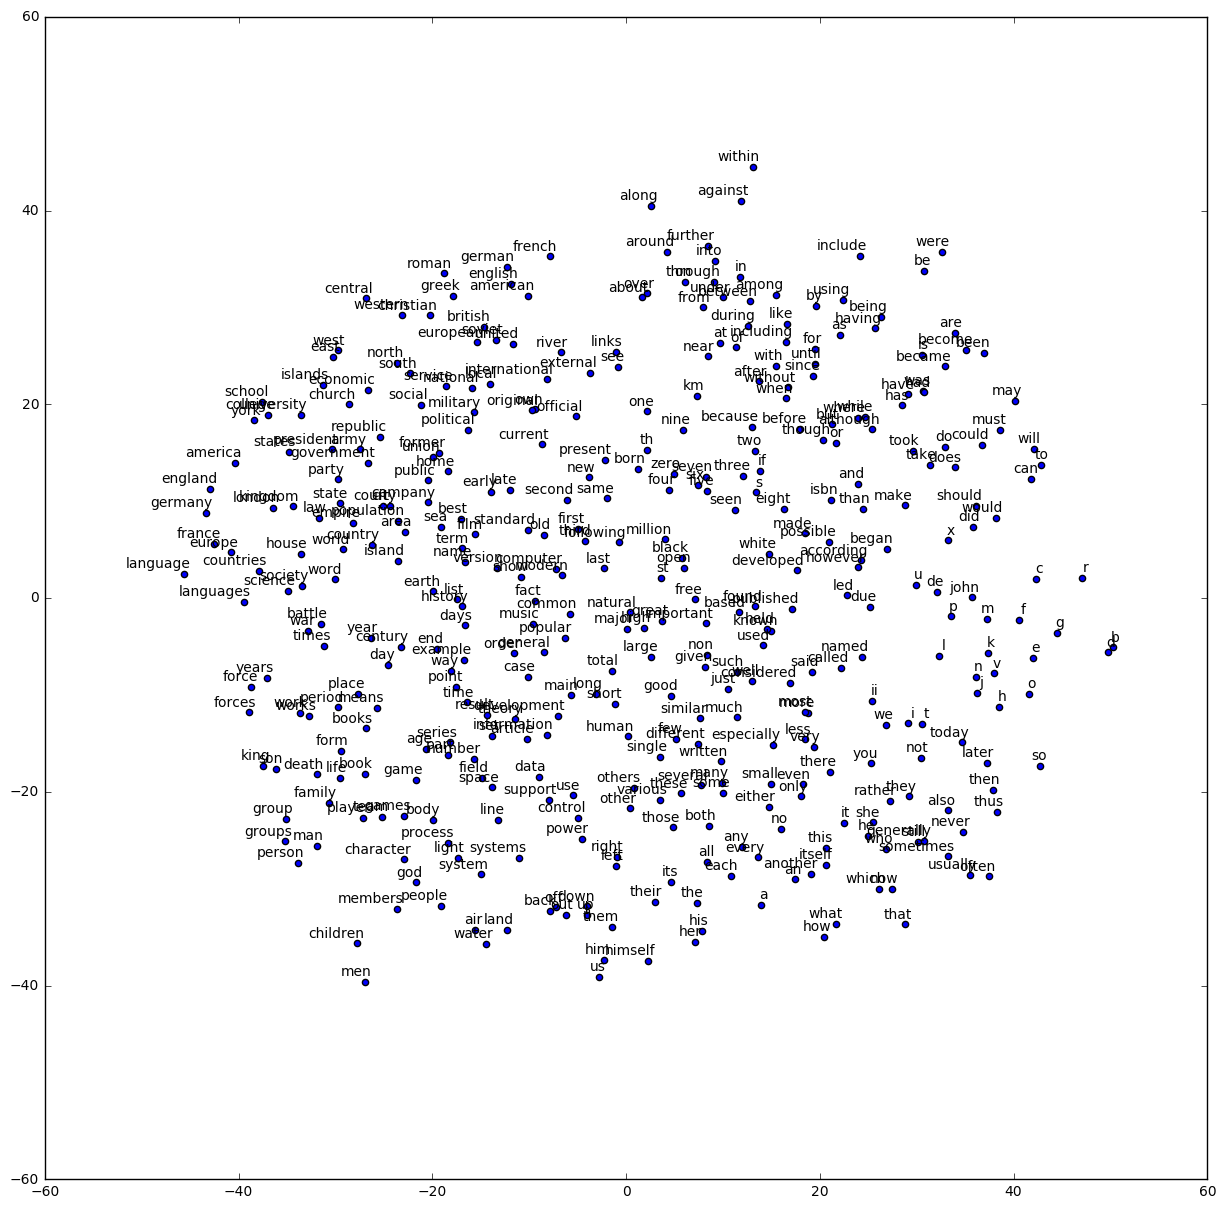

In [46]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [7]:
def generate_batch_cbow(batch_size, num_skips, skip_window):

    '''
    Batch generator for CBOW (Continuous Bag of Words).
    batch should be a shape of (batch_size, num_skips)

    Parameters
    ----------
    data: list of index of words
    batch_size: number of words in each mini-batch
    num_skips: number of surrounding words on both direction (2: one word ahead and one word following)
    skip_window: number of words at both ends of a sentence to skip (1: skip the first and last word of a sentence)
    '''

    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span) # used for collecting data[data_index] in the sliding window
    # collect the first window of words
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    # move the sliding window  
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[target]
            labels[i * num_skips + j, 0] = buffer[skip_window]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'of', 'a']
    labels: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']

with num_skips = 4 and skip_window = 2:
    batch: ['term', 'originated', 'anarchism', 'a', 'as', 'of', 'originated', 'term']
    labels: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']


In [8]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [9]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_cbow(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.889598
Nearest to three: breakaway, grasslands, bothwell, reached, axum, lederman, cruelty, sorting,
Nearest to only: vaults, gaels, loony, deadlock, glory, filk, correspondences, containers,
Nearest to d: dispersive, paints, eastwards, phonological, lives, dhrystone, rectal, wronged,
Nearest to history: baluchistan, strips, lolita, factorials, bloomberg, braun, wavell, conventional,
Nearest to however: comfortable, montpellier, gcb, foals, troy, federative, dpp, furs,
Nearest to b: pulitzer, eusebio, invisible, inhabit, universitet, diplomat, reduces, bruford,
Nearest to people: friesland, appendices, xviii, proved, spoiling, ears, gunned, brine,
Nearest to it: hostel, parentage, ginette, itv, erotic, bennett, alas, italy,
Nearest to american: eavesdropping, muse, schlesinger, characterization, onions, ogilvie, trasimene, solomon,
Nearest to or: famers, beloved, backfire, maggiore, mortensen, inclusive, commons, annexed,
Nearest to had: izzard, pe

In [10]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=3, init='pca', n_iter=5000)
three_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

In [126]:
three_d_embeddings

array([[  8.18658199, -19.13326641,   7.60059815],
       [  4.88282615,  12.11238569,  10.02270054],
       [ 20.54746378,  20.09116613,  10.41965987],
       ..., 
       [-12.73652243,  -5.78569087, -21.71477869],
       [ 12.36310263, -20.06562769,  -4.89555304],
       [-21.48124916, -18.39366776,  -0.4832973 ]])

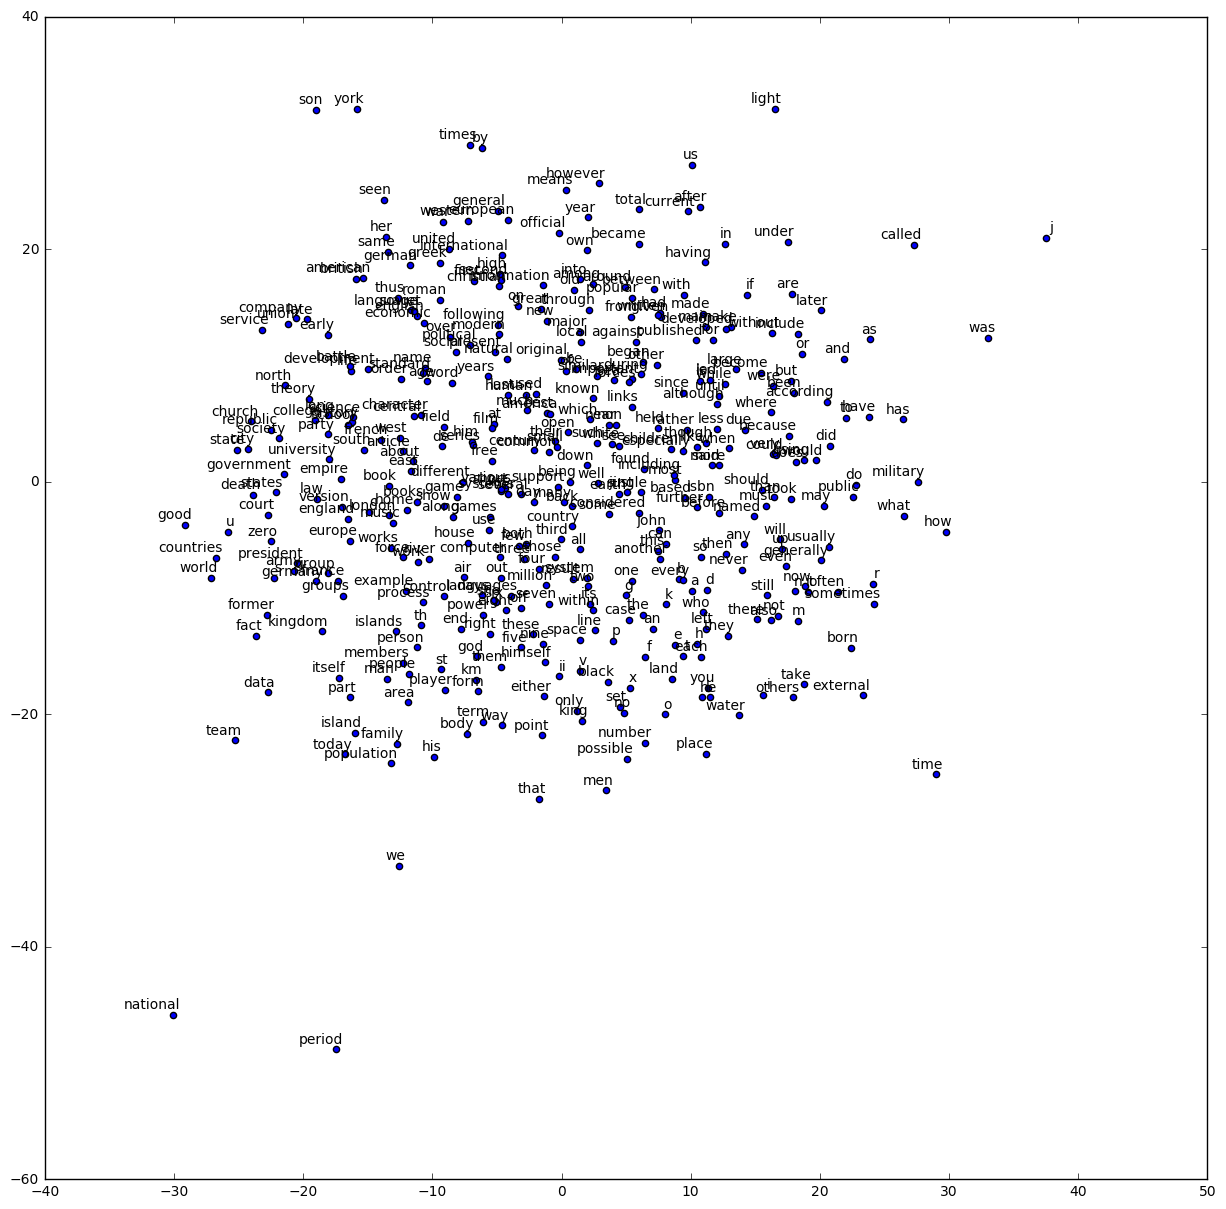

In [12]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,0:2]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(three_d_embeddings, words)

### Use plotly to plot 2D interactive scatter plot

In [18]:
import plotly.plotly as py
import plotly.graph_objs as go

py.sign_in('hzhang.wlabs','i0dfeBsSGyoQ6AdkzoWS')
# Create random data with numpy

trace_2d = go.Scatter(x = three_d_embeddings[:,0], y = three_d_embeddings[:,1], \
                    text = words, textposition = 'top center', mode = 'markers+text')
mode = [ trace_2d ]
py.iplot(mode, filename = '2d-texted-scatter')

### Use plotly to plot 3D interactive scatter plot

In [17]:
import plotly.plotly as py
import plotly.graph_objs as go

py.sign_in('hzhang.wlabs','i0dfeBsSGyoQ6AdkzoWS')
# Create random data with numpy

trace1 = go.Scatter3d(x = three_d_embeddings[:,0], y = three_d_embeddings[:,1], z = three_d_embeddings[:,2], \
                    text = words, textposition = 'top center', mode = 'markers+text')
mode = [ trace1 ]
py.iplot(mode, filename = '3d-texted-scatter')